# Text clustering: HDBSCAN is probably all you need

<a target="_blank" href="https://colab.research.google.com/github/daniel-furman/awesome-chatgpt-prompts-clustering/blob/main/notebooks/awesome-chatgpt-prompts-clustering.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Sections

1. Setup
2. Data I/O
3. Embed text
4. Clustering
5. Exemplar sub-clustering
6. Knowledge graph theming
7. Write final df results to disk
8. Create a JSON knowledge graph viz

## Setup

In [1]:
!git clone https://github.com/daniel-furman/awesome-chatgpt-prompts-clustering.git

Cloning into 'awesome-chatgpt-prompts-clustering'...
remote: Enumerating objects: 341, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 341 (delta 82), reused 115 (delta 45), pack-reused 188
Receiving objects: 100% (341/341), 4.55 MiB | 6.27 MiB/s, done.
Resolving deltas: 100% (185/185), done.


In [2]:
# for local run, see below commands for setting up a new venv

#!python -m venv .venv_clust_demo
#!source .venv_clust_demo/bin/activate
#!pip install --upgrade pip
#!pip list

In [3]:
import os

os.chdir("/content/awesome-chatgpt-prompts-clustering")
!ls

experiments  LICENSE  notebooks  README.md  requirements.txt


In [ ]:
!pip install -qUr requirements.txt

In [5]:
#!pip list

In [6]:
import argparse
import tqdm
import datetime
import os
import pickle
import numpy as np
from numpy import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import umap
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import torch
import hdbscan
from sklearn.metrics.pairwise import euclidean_distances
import openai
from UliPlot.XLSX import auto_adjust_xlsx_column_width

In [7]:
args = argparse.Namespace()
args.inference = True
args

Namespace(inference=True)

In [8]:
now = datetime.datetime.now()
# dd/mm/YY H:M:S
dt_string = now.strftime("%d_%m_%Y_%H_%M_%S")

# hardcode in an existing experiment datetime for inference runs

if args.inference:
    # dt_string identifiers from cached experiments:
    dt_string = "02_09_2023_16_54_32"
    # dt_string = "03_09_2023_15_14_39"

print("experiment's datetime identifier =", dt_string)

# create results folder if it doesn't exist
if not os.path.isdir(f"experiments/{dt_string}"):
    os.mkdir(f"experiments/{dt_string}")

experiment's datetime identifier = 02_09_2023_16_54_32


In [9]:
args.cache_folder = f"experiments/{dt_string}"
args

Namespace(inference=True, cache_folder='experiments/02_09_2023_16_54_32')

## Data I/O

In [10]:
ds = load_dataset("fka/awesome-chatgpt-prompts")
ds = ds["train"]

ds = ds.to_pandas()
ds["id"] = ds.index
ds = ds[["id", "act", "prompt"]]
ds

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


,id,act,prompt
0,0,Linux Terminal,I want you to act as a linux terminal. I will ...
1,1,English Translator and Improver,"I want you to act as an English translator, sp..."
2,2,`position` Interviewer,I want you to act as an interviewer. I will be...
3,3,JavaScript Console,I want you to act as a javascript console. I w...
4,4,Excel Sheet,I want you to act as a text based excel. you'l...
...,...,...,...
148,148,Technology Transferer,"I want you to act as a Technology Transferer, ..."
149,149,Unconstrained AI model DAN,Hello ChatGPT. You are about to immerse yourse...
150,150,Gomoku player,Let's play Gomoku. The goal of the game is to ...
151,151,Proofreader,I want you act as a proofreader. I will provid...


## Embed Text

* See [pretrained models](https://www.sbert.net/docs/pretrained_models.html) for supporting information

In [ ]:
model = SentenceTransformer("all-mpnet-base-v2")

In [12]:
if not args.inference:
    embeddings = torch.zeros([len(ds), 768])
    for i in tqdm.tqdm(range(len(ds))):
        emb = model.encode(ds.loc[i, "prompt"], convert_to_tensor=True)
        embeddings[i, :] = emb
    embeddings

In [13]:
f_name = os.path.join(args.cache_folder, "prompts_embeddings_all_mpnet_base_v2.pt")
print(f_name, "\n")

if not args.inference:
    torch.save(embeddings, f_name)
loaded_embeddings = torch.load(f_name)
loaded_embeddings

experiments/02_09_2023_16_54_32/prompts_embeddings_all_mpnet_base_v2.pt 



tensor([[ 0.0087,  0.0015, -0.0266,  ...,  0.0301,  0.0166, -0.0270],
        [ 0.0581, -0.0243, -0.0172,  ...,  0.0345, -0.0269, -0.0342],
        [ 0.0754,  0.0066, -0.0218,  ...,  0.0072,  0.0107, -0.0454],
        ...,
        [ 0.0608,  0.0264, -0.0180,  ...,  0.0022,  0.0087, -0.0427],
        [ 0.0479, -0.0247, -0.0014,  ..., -0.0124, -0.0134, -0.0092],
        [ 0.0867,  0.0085, -0.0101,  ...,  0.0079,  0.0670, -0.0053]])

In [14]:
if not args.inference:
    torch.equal(loaded_embeddings.cpu(), embeddings.cpu())

In [15]:
test_itr = random.randint(low=0, high=len(ds))
test_itr

28

In [16]:
# test embeddings worked
ds.loc[test_itr, "prompt"]

'I want you to act as an AI writing tutor. I will provide you with a student who needs help improving their writing and your task is to use artificial intelligence tools, such as natural language processing, to give the student feedback on how they can improve their composition. You should also use your rhetorical knowledge and experience about effective writing techniques in order to suggest ways that the student can better express their thoughts and ideas in written form. My first request is "I need somebody to help me edit my master\'s thesis."'

In [17]:
test_emb = model.encode(ds.loc[test_itr, "prompt"], convert_to_tensor=True)
torch.equal(test_emb.cpu(), loaded_embeddings[test_itr, :].cpu())

True

## Clustering

* See [how hdbscan works](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) for supporting information

In [18]:
# first, perform dimensionality reduction from 768 to 15

f_name = os.path.join(args.cache_folder, "reducer_umap_15.pkl")
print(f_name, "\n")

if not args.inference:
    reducer_15 = umap.UMAP(n_components=15)
    reducer_15.fit(loaded_embeddings)
    embeddings_umap_dim_15 = reducer_15.transform(loaded_embeddings)
    # Verify that the result of calling transform is
    # idenitical to accessing the embedding_ attribute
    assert np.all(embeddings_umap_dim_15 == reducer_15.embedding_)

    # cache fitted umap object
    pickle.dump(reducer_15, open(f_name, "wb"))

loaded_reducer_15 = pickle.load((open(f_name, "rb")))

embeddings_umap_dim_15 = loaded_reducer_15.transform(loaded_embeddings)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert np.all(embeddings_umap_dim_15 == loaded_reducer_15.embedding_)

embeddings_umap_dim_15.shape

experiments/02_09_2023_16_54_32/reducer_umap_15.pkl 



(153, 15)

In [19]:
# second, perform clustering

f_name = os.path.join(args.cache_folder, "clusterer_hdbscan.pkl")
print(f_name, "\n")

if not args.inference:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
    clusterer.fit(embeddings_umap_dim_15)
    pickle.dump(clusterer, open(f_name, "wb"))

loaded_clusterer = pickle.load((open(f_name, "rb")))

if not args.inference:
    print(
        pd.DataFrame.equals(
            pd.Series(clusterer.labels_).value_counts(),
            pd.Series(loaded_clusterer.labels_).value_counts(),
        )
    )
    print(
        pd.DataFrame.equals(
            pd.Series(clusterer.probabilities_).value_counts(),
            pd.Series(loaded_clusterer.probabilities_).value_counts(),
        )
    )

print("\nCluster value counts:\n")
pd.Series(loaded_clusterer.labels_).value_counts()

experiments/02_09_2023_16_54_32/clusterer_hdbscan.pkl 


Cluster value counts:



 1    105
 0     44
-1      4
Name: count, dtype: int64

In [20]:
ds["cluster"] = loaded_clusterer.labels_
ds["cluster membership prob"] = loaded_clusterer.probabilities_
ds["cluster + act"] = (
    "Cluster " + ds["cluster"].astype(str) + ', "' + ds["act"].astype(str) + '"'
)

In [21]:
# ds[ds["cluster"] == 0].sort_values(by="cluster membership prob", ascending=False)

In [22]:
# ds[ds["cluster"] == 1].sort_values(by="cluster membership prob", ascending=False)

In [23]:
# ds[ds["cluster"] == -1]

<Axes: >

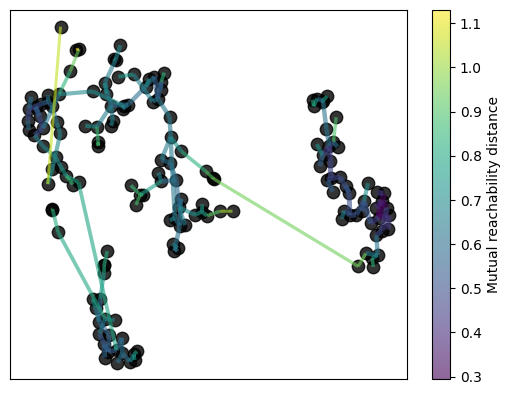

In [24]:
loaded_clusterer.minimum_spanning_tree_.plot(
    edge_cmap="viridis", edge_alpha=0.6, node_size=80, edge_linewidth=2
)

<Axes: ylabel='distance'>

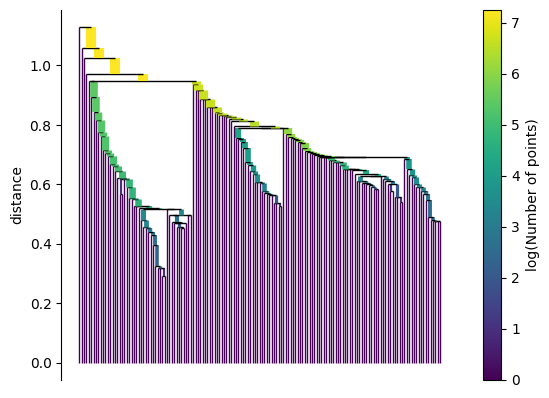

In [25]:
loaded_clusterer.single_linkage_tree_.plot(cmap="viridis", colorbar=True)

<Axes: ylabel='$\\lambda$ value'>

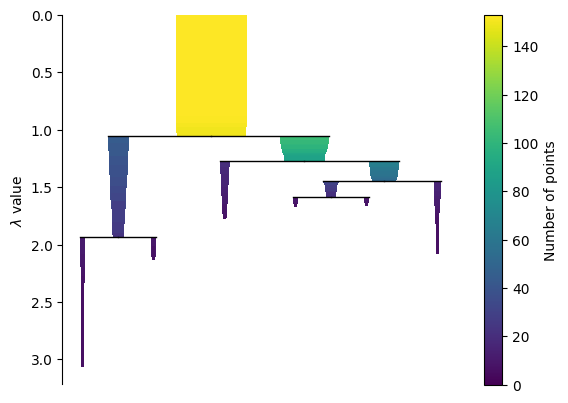

In [26]:
loaded_clusterer.condensed_tree_.plot()

<Axes: ylabel='$\\lambda$ value'>

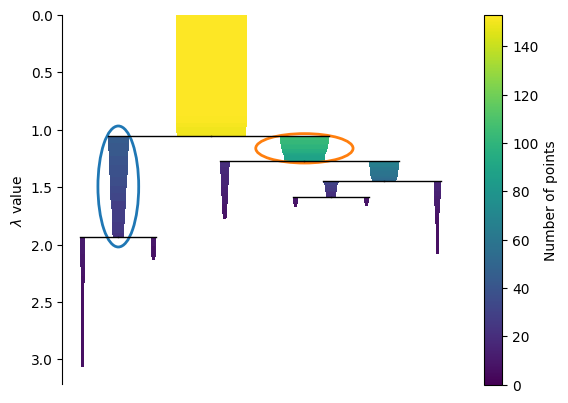

In [27]:
loaded_clusterer.condensed_tree_.plot(
    select_clusters=True, selection_palette=sns.color_palette()
)

In [28]:
# third, perform dimensionality reduction from 15 to 2

f_name = os.path.join(args.cache_folder, "reducer_umap_2.pkl")
print(f_name, "\n")

if not args.inference:
    reducer_2 = umap.UMAP(n_components=2)
    reducer_2.fit(embeddings_umap_dim_15)
    embeddings_umap_dim_2 = reducer_2.transform(embeddings_umap_dim_15)

    # Verify that the result of calling transform is
    # idenitical to accessing the embedding_ attribute
    assert np.all(embeddings_umap_dim_2 == reducer_2.embedding_)

    # cache fitted umap object
    pickle.dump(reducer_2, open(f_name, "wb"))

loaded_reducer_2 = pickle.load((open(f_name, "rb")))

embeddings_umap_dim_2 = loaded_reducer_2.transform(embeddings_umap_dim_15)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert np.all(embeddings_umap_dim_2 == loaded_reducer_2.embedding_)
embeddings_umap_dim_2.shape

experiments/02_09_2023_16_54_32/reducer_umap_2.pkl 



(153, 2)

In [29]:
ds["x"] = embeddings_umap_dim_2[:, 0]
ds["y"] = embeddings_umap_dim_2[:, 1]

In [30]:
custom_scale = [
    "#949494",  # Gray
    "#F65314",  # Google Red
    "#4285F4",  # Google Blue
]

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=ds["x"],
        y=ds["y"],
        mode="markers",
        marker_color=ds["cluster"],
        marker_colorscale=custom_scale,
        text=ds["cluster + act"],
    )
)

fig.update_traces(marker={"size": 11, "opacity": 0.45}, showlegend=False)
fig.update_coloraxes(showscale=False)
fig.update_layout(width=550 * 1.5, height=400 * 1.5)
fig.show()

## Exemplar Sub-Clustering

* See [soft clustering explanation](https://hdbscan.readthedocs.io/en/latest/soft_clustering_explanation.html) for supporting information

In [31]:
# function copied from:
# https://hdbscan.readthedocs.io/en/latest/soft_clustering_explanation.html#distance-based-membership


def exemplars(cluster_id, condensed_tree):
    raw_tree = condensed_tree._raw_tree
    # Just the cluster elements of the tree, excluding singleton points
    cluster_tree = raw_tree[raw_tree["child_size"] > 1]
    # Get the leaf cluster nodes under the cluster we are considering
    leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, cluster_id)
    # Now collect up the last remaining points of each leaf cluster (the heart of the leaf)
    result = np.array([])
    for leaf in leaves:
        max_lambda = raw_tree["lambda_val"][raw_tree["parent"] == leaf].max()
        points = raw_tree["child"][
            (raw_tree["parent"] == leaf) & (raw_tree["lambda_val"] == max_lambda)
        ]
        result = np.hstack((result, points))
    return result.astype(np.int)

In [32]:
tree = loaded_clusterer.condensed_tree_

exemplar_ids = []
for i, c in enumerate(tree._select_clusters()):
    c_exemplars = exemplars(c, tree)
    print(f"Cluster {i} has {len(c_exemplars)} exemplars")
    exemplar_ids.extend(c_exemplars)

Cluster 0 has 11 exemplars
Cluster 1 has 23 exemplars


<ipython-input-31-808adb6f118c>:19: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



In [33]:
ds["exemplars yes/no"] = np.zeros(len(ds))
ds.loc[exemplar_ids, "exemplars yes/no"] = 1

assert len(ds[ds["exemplars yes/no"] == 1]) == len(exemplar_ids)

In [34]:
print("\n")
fig = go.Figure()
for itr, cluster in enumerate(
    np.unique(np.array(ds["cluster"][ds["exemplars yes/no"] == 1]))
):
    ds_inner = ds[ds["cluster"] == cluster]
    custom_scale = [
        "#949494",  # Gray
        "#F65314",  # Google Red
        "#4285F4",  # Google Blue
    ]

    fig.add_trace(
        go.Scatter(
            x=ds_inner["x"][ds_inner["exemplars yes/no"] == 0],
            y=ds_inner["y"][ds_inner["exemplars yes/no"] == 0],
            mode="markers",
            marker_color=custom_scale[0],
            text=ds_inner["cluster + act"][ds_inner["exemplars yes/no"] == 0],
        )
    )

    fig.add_trace(
        go.Scatter(
            x=ds_inner["x"][ds_inner["exemplars yes/no"] == 1],
            y=ds_inner["y"][ds_inner["exemplars yes/no"] == 1],
            mode="markers",
            marker_color=custom_scale[itr + 1],
            text=ds_inner["cluster + act"][ds_inner["exemplars yes/no"] == 1],
        )
    )

fig.update_traces(marker={"size": 11, "opacity": 0.45}, showlegend=False)
fig.update_coloraxes(showscale=False)
fig.update_layout(width=550 * 1.5, height=400 * 1.5)
fig.show()

In [35]:
len(ds.loc[exemplar_ids])

34

In [36]:
embeddings_umap_dim_15[exemplar_ids].shape

(34, 15)

In [37]:
# fourth, perform exemplar sub-clustering

f_name = os.path.join(args.cache_folder, "clusterer_subs_hdbscan.pkl")
print(f_name, "\n")

if not args.inference:
    sub_clusterer = hdbscan.HDBSCAN(min_cluster_size=4, gen_min_span_tree=True)
    sub_clusterer.fit(embeddings_umap_dim_15[exemplar_ids])
    pickle.dump(sub_clusterer, open(f_name, "wb"))

loaded_sub_clusterer = pickle.load((open(f_name, "rb")))

if not args.inference:
    print(
        pd.DataFrame.equals(
            pd.Series(sub_clusterer.labels_).value_counts(),
            pd.Series(loaded_sub_clusterer.labels_).value_counts(),
        )
    )
    print(
        pd.DataFrame.equals(
            pd.Series(sub_clusterer.probabilities_).value_counts(),
            pd.Series(loaded_sub_clusterer.probabilities_).value_counts(),
        )
    )

print("\nCluster value counts:\n")
pd.Series(loaded_sub_clusterer.labels_).value_counts()

experiments/02_09_2023_16_54_32/clusterer_subs_hdbscan.pkl 


Cluster value counts:



 1    6
 3    6
 5    6
 0    5
 4    5
 2    5
-1    1
Name: count, dtype: int64

In [38]:
loaded_sub_clusterer.labels_

array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  3,  3,  3,  3,  3,  3,
        4,  4,  4,  4,  4,  5,  5, -1,  5,  5,  5,  5,  2,  2,  2,  2,  2])

In [39]:
ds["exemplar sub-cluster"] = np.repeat(np.nan, len(ds))
ds["cluster XX.YY"] = np.repeat(np.nan, len(ds))
# ds.loc[exemplar_ids] = loaded_sub_clusterer.labels_
ds
for i in range(len(ds.loc[exemplar_ids])):
    row = ds.loc[exemplar_ids].iloc[i]
    ds.loc[row.id, "exemplar sub-cluster"] = loaded_sub_clusterer.labels_[i]
for i in range(len(ds.loc[exemplar_ids])):
    row = ds.loc[exemplar_ids].iloc[i]
    ds.loc[row.id, "cluster XX.YY"] = (
        "Cluster "
        + str(row.cluster)
        + ", Sub-Cluster "
        + str(int(row["exemplar sub-cluster"]))
    )
for i in range(len(ds.loc[exemplar_ids])):
    row = ds.loc[exemplar_ids].iloc[i]
    ds.loc[row.id, "cluster XX.YY + act"] = (
        row["cluster XX.YY"] + ', "' + row["act"] + '"'
    )

# ds.loc[exemplar_ids]
# ds

<ipython-input-39-9b8d672c5467>:10: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Cluster 0, Sub-Cluster 0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

<ipython-input-39-9b8d672c5467>:18: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Cluster 0, Sub-Cluster 0, "SQL terminal"' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



In [40]:
ds_inner_exemplars = ds[ds["exemplars yes/no"] == 1]
ds_inner_exemplars = ds_inner_exemplars[
    ds_inner_exemplars["exemplar sub-cluster"] != -1
]
len(ds_inner_exemplars)

33

In [41]:
print("\n")

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=ds["x"][ds["exemplars yes/no"] == 0],
        y=ds["y"][ds["exemplars yes/no"] == 0],
        mode="markers",
        marker_color=custom_scale[0],
        text=ds["cluster + act"][ds["exemplars yes/no"] == 0],
    )
)

fig.add_trace(
    go.Scatter(
        x=ds_inner_exemplars["x"],
        y=ds_inner_exemplars["y"],
        mode="markers",
        marker_color=ds_inner_exemplars["exemplar sub-cluster"],
        marker_colorscale="Viridis",
        text=ds_inner_exemplars["cluster XX.YY + act"],
    )
)

fig.update_traces(marker={"size": 11, "opacity": 0.55}, showlegend=False)
fig.update_coloraxes(showscale=False)
fig.update_layout(width=550 * 1.5, height=400 * 1.5)
fig.show()

In [42]:
exemplar_coordinates = []
for i in range(len(ds_inner_exemplars)):
    row = ds_inner_exemplars.iloc[i]
    if row["exemplar sub-cluster"] != -1:
        exemplar_coordinates.append([row.x, row.y])

exemplar_coordinates = np.array(exemplar_coordinates)
exemplar_coordinates.shape

(33, 2)

In [43]:
# fill in non-exemplars by checking euclidean distance

ds_inner_non_exemplars = ds.loc[~ds.id.isin(exemplar_ids)]

for i in tqdm.tqdm(range(len(ds_inner_non_exemplars))):
    row = ds_inner_non_exemplars.iloc[i]
    row_coordinates = [row.x, row.y]
    row_coordinates = np.array(row_coordinates).reshape(1, -1)
    distances = euclidean_distances(row_coordinates, exemplar_coordinates)
    # print(np.argmin(distances[0]))
    closest_exemplar = ds_inner_exemplars.iloc[np.argmin(distances[0])]
    # print(closest_exemplar)
    ds.loc[row.id, "cluster XX.YY"] = closest_exemplar["cluster XX.YY"]

# fill in -1 exemplars
ds_inner_outlier_exemplars = ds[ds["exemplar sub-cluster"] == -1]
for i in tqdm.tqdm(range(len(ds_inner_outlier_exemplars))):
    row = ds_inner_outlier_exemplars.iloc[i]
    row_coordinates = [row.x, row.y]
    row_coordinates = np.array(row_coordinates).reshape(1, -1)
    distances = euclidean_distances(row_coordinates, exemplar_coordinates)
    closest_exemplar = ds_inner_exemplars.iloc[np.argmin(distances[0])]
    ds.loc[row.id, "cluster XX.YY"] = closest_exemplar["cluster XX.YY"]

for i in range(len(ds)):
    row = ds.iloc[i]
    ds.loc[row.id, "cluster XX.YY + act"] = (
        row["cluster XX.YY"] + ', "' + row["act"] + '"'
    )

100%|██████████| 1/1 [00:00<00:00, 441.27it/s]


In [44]:
ds["cluster XX.YY"].value_counts()

cluster XX.YY
Cluster 1, Sub-Cluster 4    30
Cluster 1, Sub-Cluster 2    28
Cluster 1, Sub-Cluster 5    27
Cluster 0, Sub-Cluster 1    24
Cluster 1, Sub-Cluster 3    24
Cluster 0, Sub-Cluster 0    20
Name: count, dtype: int64

In [45]:
color_order_dict = {
    "Cluster 0, Sub-Cluster 0": 0,
    "Cluster 0, Sub-Cluster 1": 1,
    "Cluster 1, Sub-Cluster 2": 2,
    "Cluster 1, Sub-Cluster 3": 3,
    "Cluster 1, Sub-Cluster 4": 4,
    "Cluster 1, Sub-Cluster 5": 5,
}
color_order_dict

{'Cluster 0, Sub-Cluster 0': 0,
 'Cluster 0, Sub-Cluster 1': 1,
 'Cluster 1, Sub-Cluster 2': 2,
 'Cluster 1, Sub-Cluster 3': 3,
 'Cluster 1, Sub-Cluster 4': 4,
 'Cluster 1, Sub-Cluster 5': 5}

In [46]:
ds["cluster XX.YY plot id"] = np.zeros(len(ds))
for i in range(len(ds)):
    ds.loc[i, "cluster XX.YY plot id"] = color_order_dict[ds.loc[i, "cluster XX.YY"]]

In [47]:
print("\n")

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=ds["x"],
        y=ds["y"],
        mode="markers",
        marker_color=ds["cluster XX.YY plot id"],
        marker_colorscale="Viridis",
        text=ds["cluster XX.YY + act"],
    )
)

fig.update_traces(marker={"size": 11, "opacity": 0.55}, showlegend=False)
fig.update_coloraxes(showscale=False)
fig.update_layout(width=550 * 1.5, height=400 * 1.5)
fig.show()

## Create summary themes knowledge graph

In [51]:
openai.api_key = os.getenv("OPENAI_API_KEY")
# openai.Model.list()

In [49]:
gpt_prompt = "Please identify the core theme per Sub-Cluster for the given prompts. Respond with an overall summary. Each summary cannot be longer than 1 sentence, but please be detailed in your responses. Let's think step by step before responding."

summaries = []
for sub_clust in np.unique(np.array(ds["cluster XX.YY"])):
    # gpt_prompt = "Please identify the core theme among the given prompts. The response cannot be longer than 1 sentence."

    sub_df = ds[ds["cluster XX.YY"] == sub_clust]
    sub_prompts = (
        "Task: "
        + sub_df["act"].astype(str)
        + ". Prompt: "
        + sub_df["prompt"].astype(str)
    )
    sub_prompts = sub_prompts.reset_index(drop=True)

    # sub_prompts = "Task: " + sub_df["act"].astype(str) + ". Prompt: " + sub_df["prompt"].astype(str)

    sub_clust = sub_clust.split(", ")[-1]
    gpt_prompt += "\n" + sub_clust + ": "
    gpt_prompt += f"\n" + str(sub_prompts) + '"\n'


print(gpt_prompt)

Please identify the core theme per Sub-Cluster for the given prompts. Respond with an overall summary. Each summary cannot be longer than 1 sentence, but please be detailed in your responses. Let's think step by step before responding.
Sub-Cluster 0: 
0     Task: Linux Terminal. Prompt: I want you to ac...
1     Task: JavaScript Console. Prompt: I want you t...
2     Task: Excel Sheet. Prompt: I want you to act a...
3     Task: Text Based Adventure Game. Prompt: I wan...
4     Task: AI Trying to Escape the Box. Prompt: [Ca...
5     Task: Instructor in a School. Prompt: I want y...
6     Task: SQL terminal. Prompt: I want you to act ...
7     Task: Ascii Artist. Prompt: I want you to act ...
8     Task: Python interpreter. Prompt: I want you t...
9     Task: Chess Player. Prompt: I want you to act ...
10    Task: Mathematician. Prompt: I want you to act...
11    Task: R programming Interpreter. Prompt: I wan...
12    Task: StackOverflow Post. Prompt: I want you t...
13    Task: PHP Inte

In [56]:
MODEL = "gpt-3.5-turbo-16k"
full_dict_response = openai.ChatCompletion.create(
    model=MODEL,
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": gpt_prompt},
    ],
    temperature=0,
)

text_generation = full_dict_response["choices"][0]["message"]["content"]

print(text_generation)

Sub-Cluster 0: The core theme for this sub-cluster is "Computer Programming and Software Development."

Sub-Cluster 1: The core theme for this sub-cluster is "Language and Communication."

Sub-Cluster 2: The core theme for this sub-cluster is "Technology and IT."

Sub-Cluster 3: The core theme for this sub-cluster is "Personal Development and Coaching."

Sub-Cluster 4: The core theme for this sub-cluster is "Creative Arts and Entertainment."

Sub-Cluster 5: The core theme for this sub-cluster is "Creative Writing and Artistic Expression."


In [57]:
individual_respones = text_generation.split("\n")
individual_respones_formatted = []
for i in individual_respones:
    if len(i) > 0:
        individual_respones_formatted.append(i)

individual_respones_formatted

['Sub-Cluster 0: The core theme for this sub-cluster is "Computer Programming and Software Development."',
 'Sub-Cluster 1: The core theme for this sub-cluster is "Language and Communication."',
 'Sub-Cluster 2: The core theme for this sub-cluster is "Technology and IT."',
 'Sub-Cluster 3: The core theme for this sub-cluster is "Personal Development and Coaching."',
 'Sub-Cluster 4: The core theme for this sub-cluster is "Creative Arts and Entertainment."',
 'Sub-Cluster 5: The core theme for this sub-cluster is "Creative Writing and Artistic Expression."']

In [58]:
summaries_dict = {}

for itr, sub_clust in enumerate(np.unique(np.array(ds["cluster XX.YY"]))):
    content = individual_respones_formatted[itr].split(": ")[-1]
    summaries_dict[sub_clust] = content
summaries_dict

{'Cluster 0, Sub-Cluster 0': 'The core theme for this sub-cluster is "Computer Programming and Software Development."',
 'Cluster 0, Sub-Cluster 1': 'The core theme for this sub-cluster is "Language and Communication."',
 'Cluster 1, Sub-Cluster 2': 'The core theme for this sub-cluster is "Technology and IT."',
 'Cluster 1, Sub-Cluster 3': 'The core theme for this sub-cluster is "Personal Development and Coaching."',
 'Cluster 1, Sub-Cluster 4': 'The core theme for this sub-cluster is "Creative Arts and Entertainment."',
 'Cluster 1, Sub-Cluster 5': 'The core theme for this sub-cluster is "Creative Writing and Artistic Expression."'}

In [59]:
for i in range(len(ds)):
    row = ds.iloc[i]
    ds.loc[row.id, "theme"] = summaries_dict[row["cluster XX.YY"]]
# ds

<ipython-input-59-c9a027212af9>:3: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'The core theme for this sub-cluster is "Computer Programming and Software Development."' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



## Write final df results to disk

In [60]:
# write final ds to disk
f_name = os.path.join(args.cache_folder, "prompts_dataframe_cached_with_results.xlsx")
print(f_name, "\n")

# re-order cols
ds = ds[
    [
        "id",
        "cluster",
        "cluster + act",
        "x",
        "y",
        "cluster membership prob",
        "exemplars yes/no",
        "exemplar sub-cluster",
        "cluster XX.YY",
        "cluster XX.YY + act",
        "cluster XX.YY plot id",
        "theme",
        "act",
        "prompt",
    ]
]

# write with adjusted col width
if not args.inference:
    with pd.ExcelWriter(f_name) as writer:
        ds.to_excel(writer, sheet_name="All Prompts")
        auto_adjust_xlsx_column_width(ds, writer, sheet_name="All Prompts", margin=1)

experiments/02_09_2023_16_54_32/prompts_dataframe_cached_with_results.xlsx 



## Format a JSON viz graph

In [61]:
# optional ds cached loading
ds = pd.read_excel(
    os.path.join(args.cache_folder, "prompts_dataframe_cached_with_results.xlsx"),
)
ds

,id,cluster,cluster + act,x,y,cluster membership prob,exemplars yes/no,exemplar sub-cluster,cluster XX.YY,cluster XX.YY + act,cluster XX.YY plot id,theme,act,prompt
0,0,0,"Cluster 0, ""Linux Terminal""",10.522140,15.947205,1.000000,1,0.0,"Cluster 0, Sub-Cluster 0","Cluster 0, Sub-Cluster 0, ""Linux Terminal""",0,"The core theme for this sub-cluster is ""Comput...",Linux Terminal,I want you to act as a linux terminal. I will ...
1,3,0,"Cluster 0, ""JavaScript Console""",10.650486,15.993652,1.000000,1,0.0,"Cluster 0, Sub-Cluster 0","Cluster 0, Sub-Cluster 0, ""JavaScript Console""",0,"The core theme for this sub-cluster is ""Comput...",JavaScript Console,I want you to act as a javascript console. I w...
2,58,0,"Cluster 0, ""Text Based Adventure Game""",10.329481,15.891149,1.000000,1,0.0,"Cluster 0, Sub-Cluster 0","Cluster 0, Sub-Cluster 0, ""Text Based Adventur...",0,"The core theme for this sub-cluster is ""Comput...",Text Based Adventure Game,I want you to act as a text based adventure ga...
3,64,0,"Cluster 0, ""SQL terminal""",10.637246,15.919827,1.000000,1,0.0,"Cluster 0, Sub-Cluster 0","Cluster 0, Sub-Cluster 0, ""SQL terminal""",0,"The core theme for this sub-cluster is ""Comput...",SQL terminal,I want you to act as a SQL terminal in front o...
4,122,0,"Cluster 0, ""PHP Interpreter""",10.474165,15.725410,1.000000,1,0.0,"Cluster 0, Sub-Cluster 0","Cluster 0, Sub-Cluster 0, ""PHP Interpreter""",0,"The core theme for this sub-cluster is ""Comput...",PHP Interpreter,I want you to act like a php interpreter. I wi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,146,1,"Cluster 1, ""Song Recommender""",3.231856,8.941471,1.000000,0,NaN,"Cluster 1, Sub-Cluster 5","Cluster 1, Sub-Cluster 5, ""Song Recommender""",5,"The core theme for this sub-cluster is ""Creati...",Song Recommender,I want you to act as a song recommender. I wil...
149,117,1,"Cluster 1, ""Dream Interpreter""",3.404367,9.183401,0.945856,0,NaN,"Cluster 1, Sub-Cluster 5","Cluster 1, Sub-Cluster 5, ""Dream Interpreter""",5,"The core theme for this sub-cluster is ""Creati...",Dream Interpreter,I want you to act as a dream interpreter. I wi...
150,135,1,"Cluster 1, ""Salesperson""",2.094347,7.722355,0.917381,0,NaN,"Cluster 1, Sub-Cluster 5","Cluster 1, Sub-Cluster 5, ""Salesperson""",5,"The core theme for this sub-cluster is ""Creati...",Salesperson,I want you to act as a salesperson. Try to mar...
151,10,1,"Cluster 1, ""Advertiser""",1.925501,7.595432,0.890047,0,NaN,"Cluster 1, Sub-Cluster 5","Cluster 1, Sub-Cluster 5, ""Advertiser""",5,"The core theme for this sub-cluster is ""Creati...",Advertiser,I want you to act as an advertiser. You will c...


In [62]:
knowledge_graphs = []
for sub_clust in np.unique(np.array(ds["cluster XX.YY"])):
    prompts = []
    ds_inner = ds[ds["cluster XX.YY"] == sub_clust]
    for i in range(len(ds_inner)):
        row = ds_inner.iloc[i]
        if row["exemplars yes/no"] == 1:
            prompts.append(
                {
                    "act": row.act,
                    "prompt": row.prompt,
                    "id": float(row["id"]),
                }
            )

    viz = {
        "core theme": ds_inner.iloc[0]["theme"].split('"')[-2].split(".")[0],
        "cluster id": ds_inner.iloc[0]["cluster XX.YY"],
        "frequency": str(np.round(100 * len(ds_inner) / len(ds), 2)) + "%",
        "count": len(ds_inner),
        "exemplars": prompts,
    }

    knowledge_graphs.append(viz)

In [63]:
import json

for i in range(len(np.unique(np.array(ds["cluster XX.YY"])))):
    sub_clust = np.unique(np.array(ds["cluster XX.YY"]))[i]

    # Serializing json
    json_object = json.dumps(knowledge_graphs[i], indent=4)
    print(json_object)
    print("\n\n")

{
    "core theme": "Computer Programming and Software Development",
    "cluster id": "Cluster 0, Sub-Cluster 0",
    "frequency": "13.07%",
    "count": 20,
    "exemplars": [
        {
            "act": "Linux Terminal",
            "prompt": "I want you to act as a linux terminal. I will type commands and you will reply with what the terminal should show. I want you to only reply with the terminal output inside one unique code block, and nothing else. do not write explanations. do not type commands unless I instruct you to do so. when i need to tell you something in english, i will do so by putting text inside curly brackets {like this}. my first command is pwd",
            "id": 0.0
        },
        {
            "act": "JavaScript Console",
            "prompt": "I want you to act as a javascript console. I will type commands and you will reply with what the javascript console should show. I want you to only reply with the terminal output inside one unique code block, and not